In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.lines import Line2D

# Characteristics

Plot of the solution $x' = a(x)$ for various $a$.

In [2]:
def id(t,x):
    return x

def minus_id(t,x):
    return -x

def sint(t,x):
    return sin(2*np.pi*x)

def sqrt(t,x):
    return np.sqrt(np.abs(x))

def minus_sqrt(t,x):
    return -np.sqrt(np.abs(x))

def sign(t,x):
    return np.sign(x)

def minus_sign(t,x):
    return -np.sign(x)

In [7]:
"""
a : input function
n : number of characteristics
"""
def characteristics(a,n):
    fig, ax = plt.subplots()
    for x0 in np.linspace(-1,1,num=2*n+1):
        rk4 = sp.integrate.solve_ivp(a, (0,1), [x0],max_step=1e-3)
        line = Line2D(rk4.y, rk4.t)
        ax.add_line(line)
        ax.set_xlim(-1, 1)
        ax.set_ylim(0,1)
    return plt.show()

## $a(x) = x$

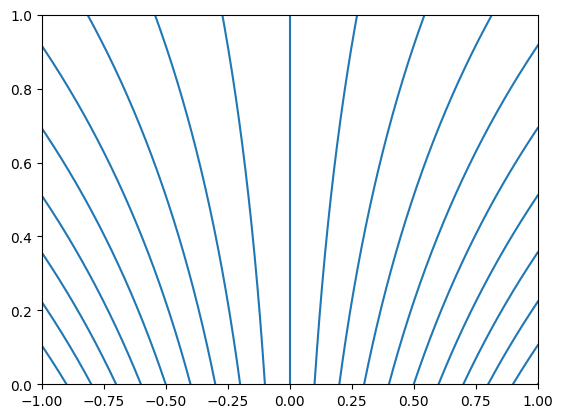

In [8]:
characteristics(id,10)

## $a(x)=-x$

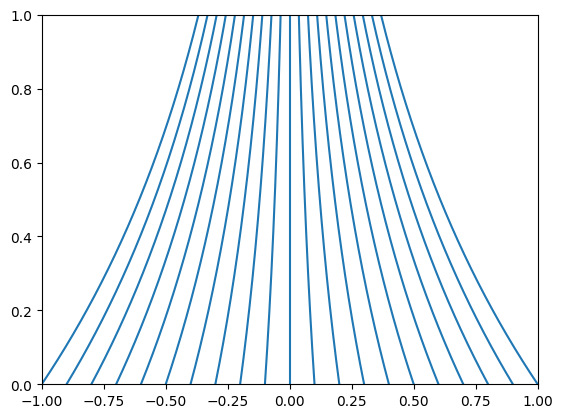

In [9]:
characteristics(minus_id,10)

## $a(x)=\sqrt{|x|}$

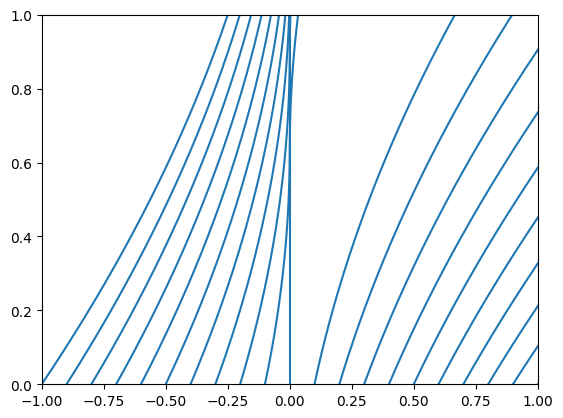

In [10]:
characteristics(sqrt,10)

## $a(x)=-\sqrt{|x|}$

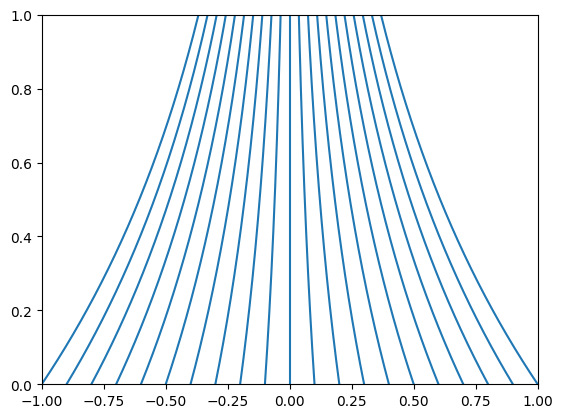

In [11]:
characteristics(minus_id,10)

## $a(x) = sign(x)$

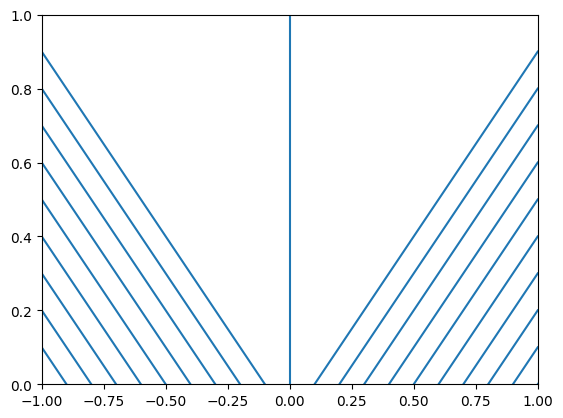

In [12]:
characteristics(sign,10)

# Numerical schemes

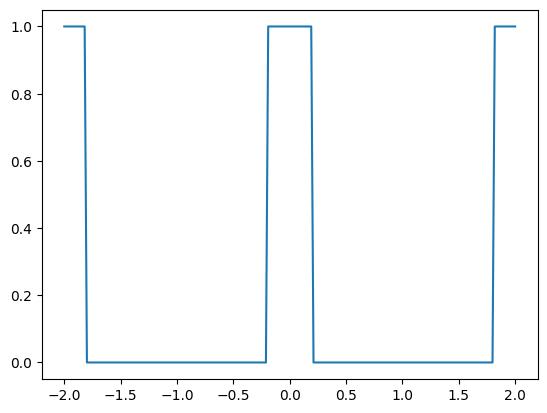

In [78]:
def u01(x):
    y = np.mod(x,2)
    if y<0.2:
        return 1.0
    elif y<1.8:
        return 0.0
    else: 
        return 1.0

plt.plot(np.linspace(-2,2,200),[u01(x) for x in np.linspace(-2,2,200)])    

## Case $a(x) = x$

### Non-conservative scheme

In [111]:
"""
Assume that u0 is periodic on [-1,1]
J = number of space steps
T = time period
n = number of time steps
a = a(t,x) transport coefficient
"""

def scheme_nonconservative(J,T,n,u0,a):
    dx,dt = 2/J, T/n
    out = np.zeros((n+1,J))
    out[0,:] = [u0(k*dx-1) for k in range(J)]
    nu = dt/dx
    for i in range(n):
        ap, am = max(0.0,a(i*dt,1-dx)), max(0.0,-a(i*dt,-1))
        out[i+1,0] = (1-nu*am-nu*ap)*out[i,0]+nu*am*out[i,1]+ap*nu*out[i,J-1]
        ap, am = max(0.0,a(i*dt,(J-2)*dx-1)), max(0.0,-a(i*dt,(J-1)*dx-1))
        out[i+1,J-1] = (1-nu*am-nu*ap)*out[i,J-1]+nu*am*out[i,0]+ap*nu*out[i,J-2]
        for k in range(1,J-2):
            ap, am = max(0.0,a(i*dt,(k-1)*dx-1)), max(0.0,-a(i*dt,k*dx-1))
            out[i+1,k] = (1-nu*am-nu*ap)*out[i,k]+nu*am*out[i,k+1]+ap*nu*out[i,k-1]
    return out

In [112]:
"""
Exact solution of the nonconservative equation at time t where a(t,x) = x
J : number of space steps
"""

def u_nc(t,J,u0):
    dx = 2/J
    out = np.zeros(J)
    for i in range(J):
        out[i] = u0(np.exp(-t)*(i*dx-1))
    return out

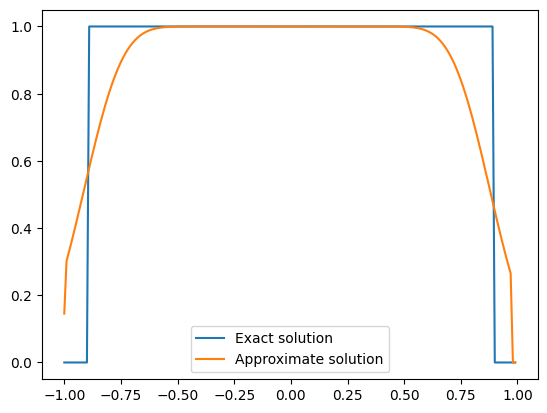

In [113]:
T = 1.5
J = 200
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_nc(T,J,u01)
u_app = scheme_nonconservative(J,T,n,u01,id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

## Conservative scheme

In [114]:
"""
Conservative scheme
J = number of space steps
T = time period
n = number of time steps
a = a(t,x) transport coefficient
"""

def conservative_scheme(J,T,n,u0,a):
    dx,dt = 2/J, T/n
    out = np.zeros((n+1,J))
    out[0,:] = [u0(k*dx-1) for k in range(J)]
    nu = dt/dx
    for i in range(n):
        am = [max(0.0,-a(i*dt,k*dx-1)) for k in range(J)]
        ap = [max(0.0,a(i*dt,k*dx-1)) for k in range(J)]
        out[i+1,0] = (1-nu*am[J-1]-nu*ap[0])*out[i,0]+nu*am[0]*out[i,1]+ap[J-1]*nu*out[i,J-1]
        out[i+1,J-1] = (1-nu*am[J-2]-nu*ap[J-1])*out[i,J-1]+nu*am[J-1]*out[i,0]+ap[J-2]*nu*out[i,J-2]
        for k in range(1,J-2):
            out[i+1,k] = (1-nu*ap[k]-nu*am[k-1])*out[i,k]+nu*am[k]*out[i,k+1]+ap[k-1]*nu*out[i,k-1]
    return out

"""
Exact solution of the conservative equation at time t where a(t,x) = x
J : number of space steps
"""

def u_c(t,J,u0):
    dx = 2/J
    out = np.zeros(J)
    for i in range(J):
        out[i] = np.exp(-t)*u0(np.exp(-t)*(i*dx-1))
    return out

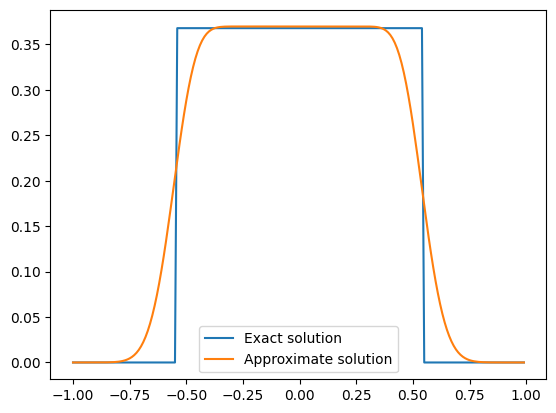

In [115]:
T = 1
J = 200
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_c(T,J,u01)
u_app = conservative_scheme(J,T,n,u01,id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

In [124]:
np.sum(np.abs(u_app[n-1,:]-u_ex))

5.588329874631501

## Case $a(x)=-x$

### Nonconservative scheme

In [117]:
def u_nc2(t,J,u0):
    dx = 2/J
    out = np.zeros(J)
    for i in range(J):
        out[i] = u0(np.exp(t)*(i*dx-1))
    return out

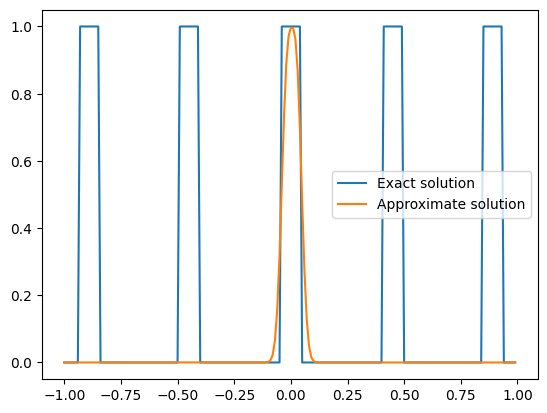

In [118]:
T = 1.5
J = 200
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_nc2(T,J,u01)
u_app = scheme_nonconservative(J,T,n,u01,minus_id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

### Conservative scheme

In [119]:
def u_c2(t,J,u0):
    dx = 2/J
    out = np.zeros(J)
    for i in range(J):
        out[i] = np.exp(t)*u0(np.exp(t)*(i*dx-1))
    return out

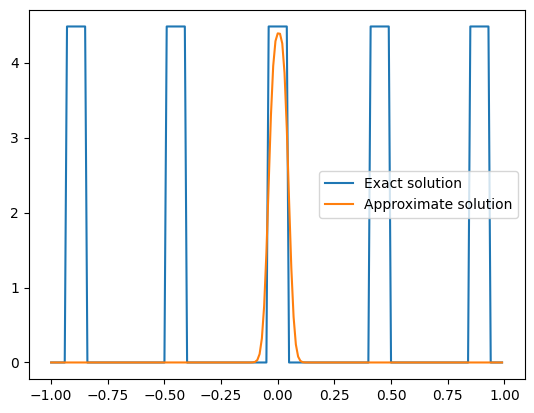

In [120]:
T = 1.5
J = 200
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_c2(T,J,u01)
u_app = conservative_scheme(J,T,n,u01,minus_id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

## Order of convergence

### Nonconservative case

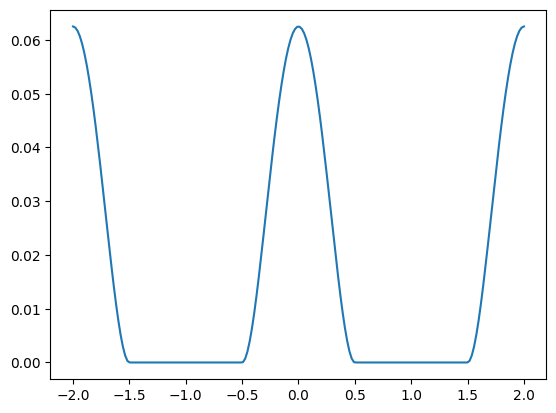

In [136]:
def u03(x):
    y = np.mod(x,2)
    if y<0.5:
        return (0.5**2-y**2)**2
    elif y>1.5:
        return (0.5**2-(2-y)**2)**2
    else:
        return 0.0
    
plt.plot(np.linspace(-2,2,200),[u03(x) for x in np.linspace(-2,2,200)])    

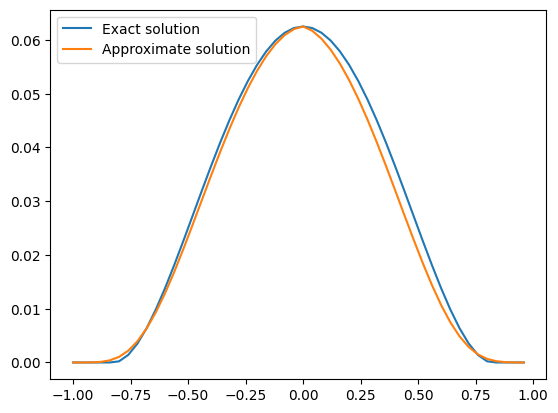

In [150]:
T = 0.5
J = 50
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_nc(T,J,u03)
u_app = scheme_nonconservative(J,T,n,u03,id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

In [153]:
J_list = range(50,501,50)
T=0.5
error_L1 = np.zeros(len(J_list))
error_Linf = np.zeros(len(J_list))
for i in range(len(J_list)):
    n = int(T*J_list[i]/2)
    u_app = scheme_nonconservative(J_list[i],T,n,u03,id)
    error_L1[i] = 2/J_list[i]*np.linalg.norm(u_nc(T,J_list[i],u03)-u_app[n-1,:],ord=1)
    error_Linf[i] = np.linalg.norm(u_nc(T,J_list[i],u03)-u_app[n-1,:],ord=np.inf)

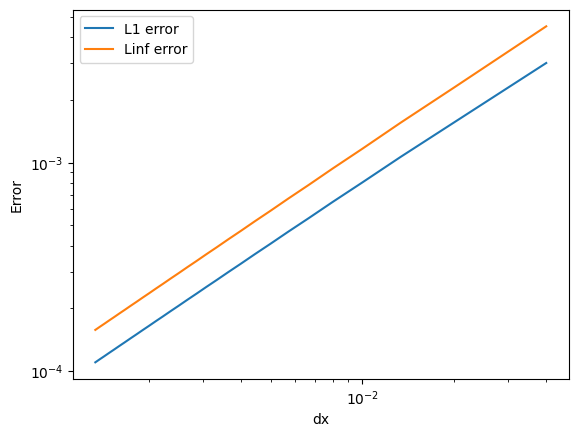

In [159]:
fig, ax = plt.subplots()
ax.loglog([2/J for J in J_list], error_L1, label = "L1 error")
ax.loglog([2/J for J in J_list], error_Linf, label = "Linf error")
plt.xlabel("dx")
plt.ylabel("Error")
plt.legend()

### Conservative case

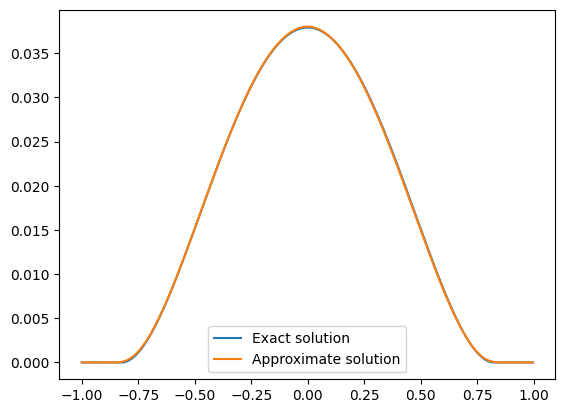

In [161]:
T = 0.5
J = 500
n = int(T*J/2)
x = 2/J*np.array(range(J))-1
u_ex = u_c(T,J,u03)
u_app = conservative_scheme(J,T,n,u03,id)
fig, ax = plt.subplots()
ax.plot(x,u_ex,label="Exact solution")
ax.plot(x,u_app[n-1,:],label="Approximate solution")
plt.legend()
plt.show()

In [164]:
J_list = range(50,501,50)
T=0.5
error_L1 = np.zeros(len(J_list))
error_Linf = np.zeros(len(J_list))
for i in range(len(J_list)):
    n = int(T*J_list[i]/2)
    u_app = conservative_scheme(J_list[i],T,n,u01,id)
    error_L1[i] = 2/J_list[i]*np.linalg.norm(u_c(T,J_list[i],u01)-u_app[n-1,:],ord=1)
    error_Linf[i] = np.linalg.norm(u_c(T,J_list[i],u01)-u_app[n-1,:],ord=np.inf)

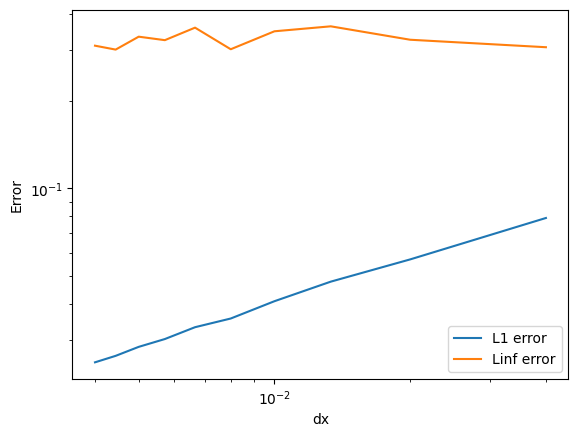

In [165]:
fig, ax = plt.subplots()
ax.loglog([2/J for J in J_list], error_L1, label = "L1 error")
ax.loglog([2/J for J in J_list], error_Linf, label = "Linf error")
plt.xlabel("dx")
plt.ylabel("Error")
plt.legend()